In [2]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
import scipy.sparse as sparse
font = {'family' : 'Arial',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
path_to_save = "../results/Figures/Figure 2/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

## Read PBMC Dataset

In [4]:
pbmc = sc.read("../data/train_pbmc.h5ad")
pbmc.obs["cell_type"].replace("CD4T", "CD4-T", inplace=True)
pbmc.obs["cell_type"].replace("CD8T", "CD8-T", inplace=True)
pbmc.obs["cell_type"].replace("Dendritic", "DC", inplace=True)
pbmc.obs["cell_type"].replace("FCGR3A+Mono", "F-Mono", inplace=True)
pbmc.obs["cell_type"].replace("CD14+Mono", "CD14-Mono", inplace=True)
pbmc

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [5]:
cd4t = pbmc[pbmc.obs["cell_type"] == "CD4-T"]
cd4t

View of AnnData object with n_obs × n_vars = 5564 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

### Figure 2.a

... storing 'cell_type' as categorical


saving figure to file ../results/Figures/Figure 2/umap_conditions.pdf


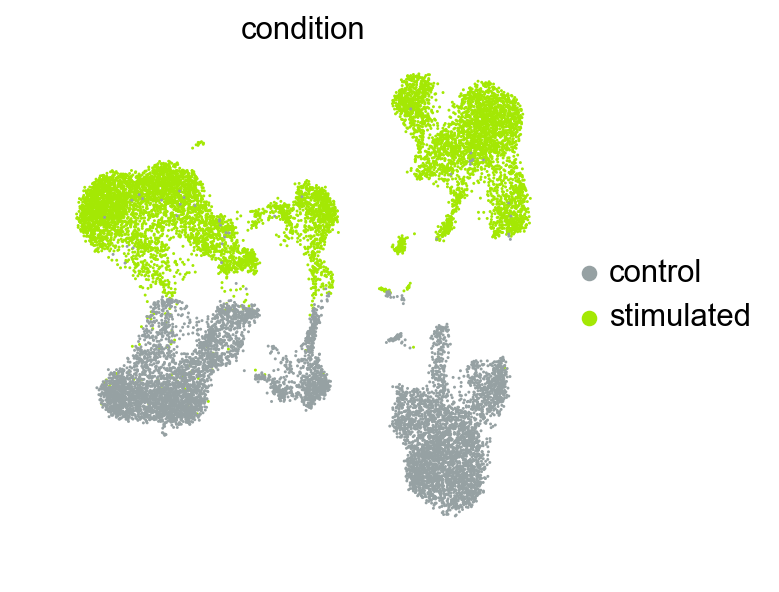

In [6]:
sc.set_figure_params(fontsize=14)
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)
sc.pl.umap(pbmc, color=["condition"],
           legend_fontsize=14,
           palette=["#96a1a3", "#A4E804"],
           save=f"_conditions.pdf",
           show=True, 
           frameon=False)
os.rename(src=os.path.join(path_to_save, "umap_conditions.pdf"), 
          dst=os.path.join(path_to_save, "Fig2a_umap_conditions.pdf"))

saving figure to file ../results/Figures/Figure 2/umap_celltypes.pdf


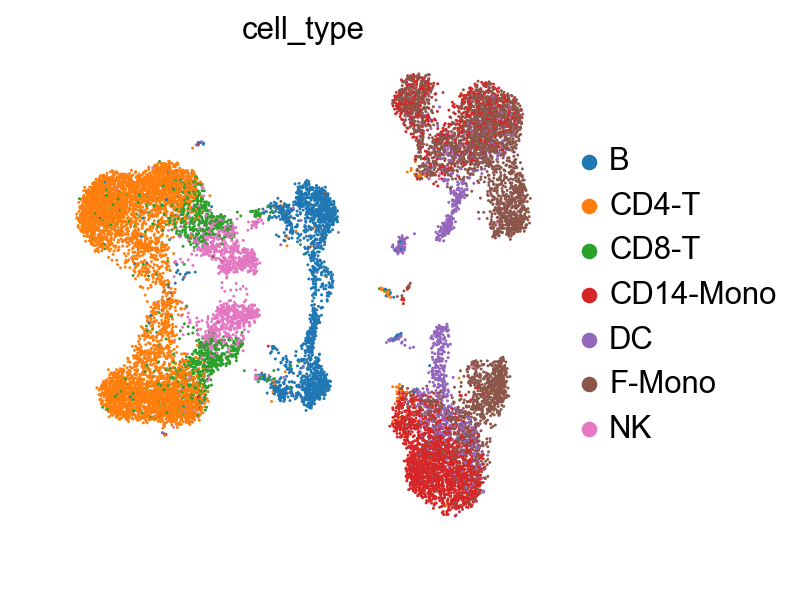

In [7]:
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)
sc.pl.umap(pbmc, color=["cell_type"],
           legend_fontsize=14,
           save=f"_celltypes.pdf",
           show=True,
           frameon=False)
os.rename(src=os.path.join(path_to_save, "umap_celltypes.pdf"), 
          dst=os.path.join(path_to_save, "Fig2a_umap_celltypes.pdf"))

### Figure 2.b

In [8]:
pbmc_reconstructed = sc.read("../data/reconstructed/scGen/pbmc.h5ad")
pbmc_reconstructed

AnnData object with n_obs × n_vars = 24900 × 6998 
    obs: 'batch', 'cell_type', 'condition'

In [9]:
network = scgen.VAEArith(z_dimension=100, 
                         x_dimension=pbmc.shape[1],
                         model_path="../models/scGen/pbmc/CD4T/scgen")
network.restore_model()

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen


In [10]:
conditions = {"ctrl": "CD4T_ctrl", "pred_stim": "CD4T_pred_stim", "real_stim": "CD4T_real_stim"}
cd4t_reconstructed = pbmc_reconstructed[pbmc_reconstructed.obs["condition"].isin(conditions.values())]
cd4t_reconstructed

View of AnnData object with n_obs × n_vars = 8001 × 6998 
    obs: 'batch', 'cell_type', 'condition'

In [11]:
cd4t = pbmc[pbmc.obs["cell_type"] == "CD4-T"]
sc.tl.rank_genes_groups(cd4t, groupby="condition", n_genes=100, method="wilcoxon")
diff_genes_cd4t = cd4t.uns["rank_genes_groups"]["names"]["stimulated"]

In [12]:
def replace_conditions(adata):
    adata.obs["condition"].replace("CD4T_ctrl", "CD4-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD4T_real_stim", "CD4-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD4T_pred_stim", "CD4-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD8T_ctrl", "CD8-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD8T_real_stim", "CD8-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD8T_pred_stim", "CD8-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("Dendritic_ctrl", "DC_ctrl", inplace=True)
    adata.obs["condition"].replace("Dendritic_real_stim", "DC_real_stim", inplace=True)
    adata.obs["condition"].replace("Dendritic_pred_stim", "DC_pred_stim", inplace=True)

    adata.obs["condition"].replace("FCGR3A+Mono_ctrl", "F-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_real_stim", "F-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_pred_stim", "F-Mono_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD14+Mono_ctrl", "CD14-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_real_stim", "CD14-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_pred_stim", "CD14-Mono_pred_stim", inplace=True)
def replace_cell_types(adata):
    adata.obs["cell_type"].replace("CD4T", "CD4-T", inplace=True)
    adata.obs["cell_type"].replace("CD8T", "CD8-T", inplace=True)
    adata.obs["cell_type"].replace("Dendritic", "DC", inplace=True)
    adata.obs["cell_type"].replace("FCGR3A+Mono", "F-Mono", inplace=True)
    adata.obs["cell_type"].replace("CD14+Mono", "CD14-Mono", inplace=True)

In [13]:
conditions = {"ctrl": "CD4-T_ctrl", "pred_stim": "CD4-T_pred_stim", "real_stim": "CD4-T_real_stim"}

In [14]:
replace_conditions(pbmc_reconstructed)
replace_conditions(cd4t_reconstructed)
replace_cell_types(pbmc_reconstructed)
replace_cell_types(cd4t_reconstructed)

0.9725512453489008
0.9713736215099469


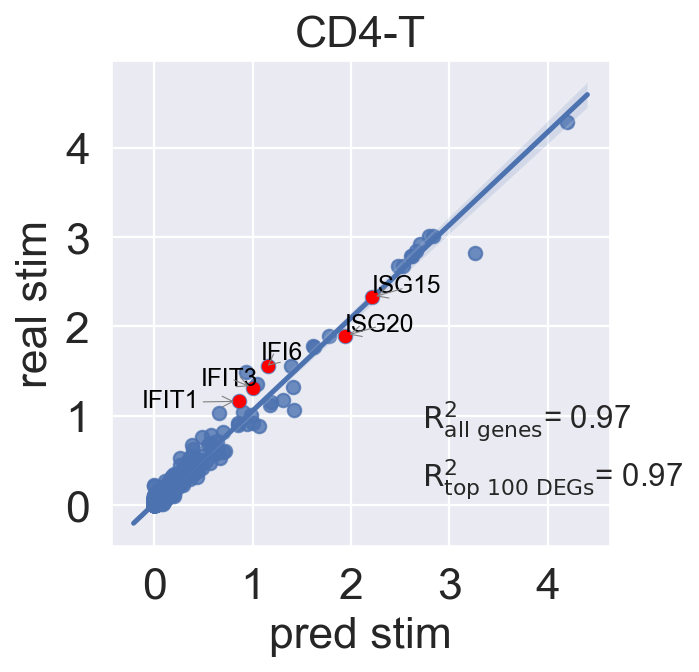

In [15]:
sns.set()
scgen.plotting.reg_mean_plot(cd4t_reconstructed, 
                             condition_key="condition",
                             axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                             gene_list=diff_genes_cd4t[:5],
                             top_100_genes=diff_genes_cd4t,
                             path_to_save=os.path.join(path_to_save, f"Fig2b_reg_mean.pdf"),
                             legend=False,
                             labels={"x": "pred stim", "y":"real stim"},
                             show=True,
                             fontsize=20,
                             textsize=14,
                             title="CD4-T",
                             x_coeff=0.35, 
                             range=[0, 5, 1])

### Fig 2.c

In [16]:
def calc_R2(adata, cell_type, n_genes=6998, conditions=None):
    if n_genes != adata.shape[1]:
        celldata = adata.copy()[adata.obs["cell_type"] == cell_type]
        print(celldata.obs["condition"].unique().tolist())
        sc.tl.rank_genes_groups(celldata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = celldata.uns["rank_genes_groups"]["names"][conditions["real_stim"]]
        adata = adata[:, diff_genes.tolist()]
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
    for i in range(100):
        pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.8 * pred_stim.shape[0]))
        real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.8 * real_stim.shape[0]))
        if sparse.issparse(pred_stim.X):
            pred_stim.X = pred_stim.X.A
            real_stim.X = real_stim.X.A
        x = np.average(pred_stim.X[pred_stim_idx], axis=0)
        y = np.average(real_stim.X[real_stim_idx], axis=0)
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        r_values[0, i] = r_value ** 2
    return r_values.mean(), r_values.std()

In [17]:
def calc_R2_mean_var(adata, cell_types, n_genes):
    r2_means, r2_vars = [], []
    for cell_type in cell_types:
        conditions = {"real_stim": cell_type+"_real_stim", "pred_stim": cell_type+"_pred_stim"}
        r2_mean, r2_var = calc_R2(adata, cell_type, n_genes=n_genes, conditions=conditions)
        r2_means.append(r2_mean)
        r2_vars.append(r2_var)
    return r2_means, r2_vars

In [18]:
def calc_R2_specific_model(adata, n_genes, conditions):
    if n_genes != adata.shape[1]:
        sc.tl.rank_genes_groups(adata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = adata.uns["rank_genes_groups"]["names"][conditions["real_stim"]]
        adata = adata[:, diff_genes.tolist()]
    r2_means, r2_vars = [], []
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
    for i in range(100):
        pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.8 * pred_stim.shape[0]))
        real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.8 * real_stim.shape[0]))
        if sparse.issparse(pred_stim.X):
            pred_stim.X = pred_stim.X.A
            real_stim.X = real_stim.X.A
        x = np.average(pred_stim.X[pred_stim_idx], axis=0)
        y = np.average(real_stim.X[real_stim_idx], axis=0)
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        r_values[0, i] = r_value ** 2
    print(r_values.mean(), r_values.std())
    return r_values.mean(), r_values.std()

In [19]:
cell_types_colnames = ["B", "CD14-Mono", "CD4-T", "CD8-T", "DC", "F-Mono", "NK"]
cell_types = ["B", "CD14-Mono", "CD4-T", "CD8-T", "DC", "F-Mono", "NK"]
r2_top100_means, r2_top100_vars = calc_R2_mean_var(pbmc_reconstructed, cell_types=cell_types_colnames, n_genes=100)
r2_all_means, r2_all_vars = calc_R2_mean_var(pbmc_reconstructed, cell_types=cell_types_colnames, n_genes=pbmc_reconstructed.shape[1])

... storing 'cell_type' as categorical
... storing 'condition' as categorical


['B_ctrl', 'B_pred_stim', 'B_real_stim']


... storing 'cell_type' as categorical
... storing 'condition' as categorical


['CD14-Mono_ctrl', 'CD14-Mono_pred_stim', 'CD14-Mono_real_stim']


... storing 'cell_type' as categorical
... storing 'condition' as categorical


['CD4-T_ctrl', 'CD4-T_pred_stim', 'CD4-T_real_stim']


... storing 'cell_type' as categorical
... storing 'condition' as categorical


['CD8-T_ctrl', 'CD8-T_pred_stim', 'CD8-T_real_stim']


... storing 'cell_type' as categorical
... storing 'condition' as categorical


['DC_ctrl', 'DC_pred_stim', 'DC_real_stim']


... storing 'cell_type' as categorical
... storing 'condition' as categorical


['F-Mono_ctrl', 'F-Mono_pred_stim', 'F-Mono_real_stim']


... storing 'cell_type' as categorical
... storing 'condition' as categorical


['NK_ctrl', 'NK_pred_stim', 'NK_real_stim']


In [20]:
all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
all_types = ["top 100 DEGs"] * 7 + ["all genes"] * 7
cell_types_x = 2 * cell_types
df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})
print(df[df["Type"] == "top 100 DEGs"].mean())
print(df[df["Type"] == "all genes"].mean())
df

R^2 Means      0.936179
R^2 Stddevs    0.003027
dtype: float64
R^2 Means      0.948664
R^2 Stddevs    0.001867
dtype: float64


,R^2 Means,R^2 Stddevs,Type,Cell Types
0,0.965339,0.002401,top 100 DEGs,B
1,0.852905,0.006427,top 100 DEGs,CD14-Mono
2,0.987645,0.000476,top 100 DEGs,CD4-T
3,0.985148,0.001357,top 100 DEGs,CD8-T
4,0.929241,0.004175,top 100 DEGs,DC
5,0.861103,0.004082,top 100 DEGs,F-Mono
6,0.971875,0.002269,top 100 DEGs,NK
7,0.961467,0.001429,all genes,B
8,0.916630,0.003060,all genes,CD14-Mono
9,0.970795,0.000813,all genes,CD4-T


In [21]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=18)


In [22]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=False, legend=False, offset=0.375):
    plt.close("all")
#     import matplotlib
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=30)
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
    plt.figure(figsize=(12, 10))
#     g = sns.catplot(x=cat, y=val, hue=subcat, data=df, kind='bar', palette="muted", height=6, legend=False)
#     g.despine(left=True)
#     plt.yticks(np.arange(0, 1.2, 0.2))
#     g.set_xticklabels(rotation=90)
#     g.set_xlabels("")
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values)
        a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
#         print(a.shape)
#         dfc=pd.DataFrame({'x': x_pos + i/1.25, 'y': a[0]})
        plt.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=25)
    plt.xticks(x_pos+offset, u, rotation=90)
    if legend:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_save, filename), dpi=100)
    plt.show()

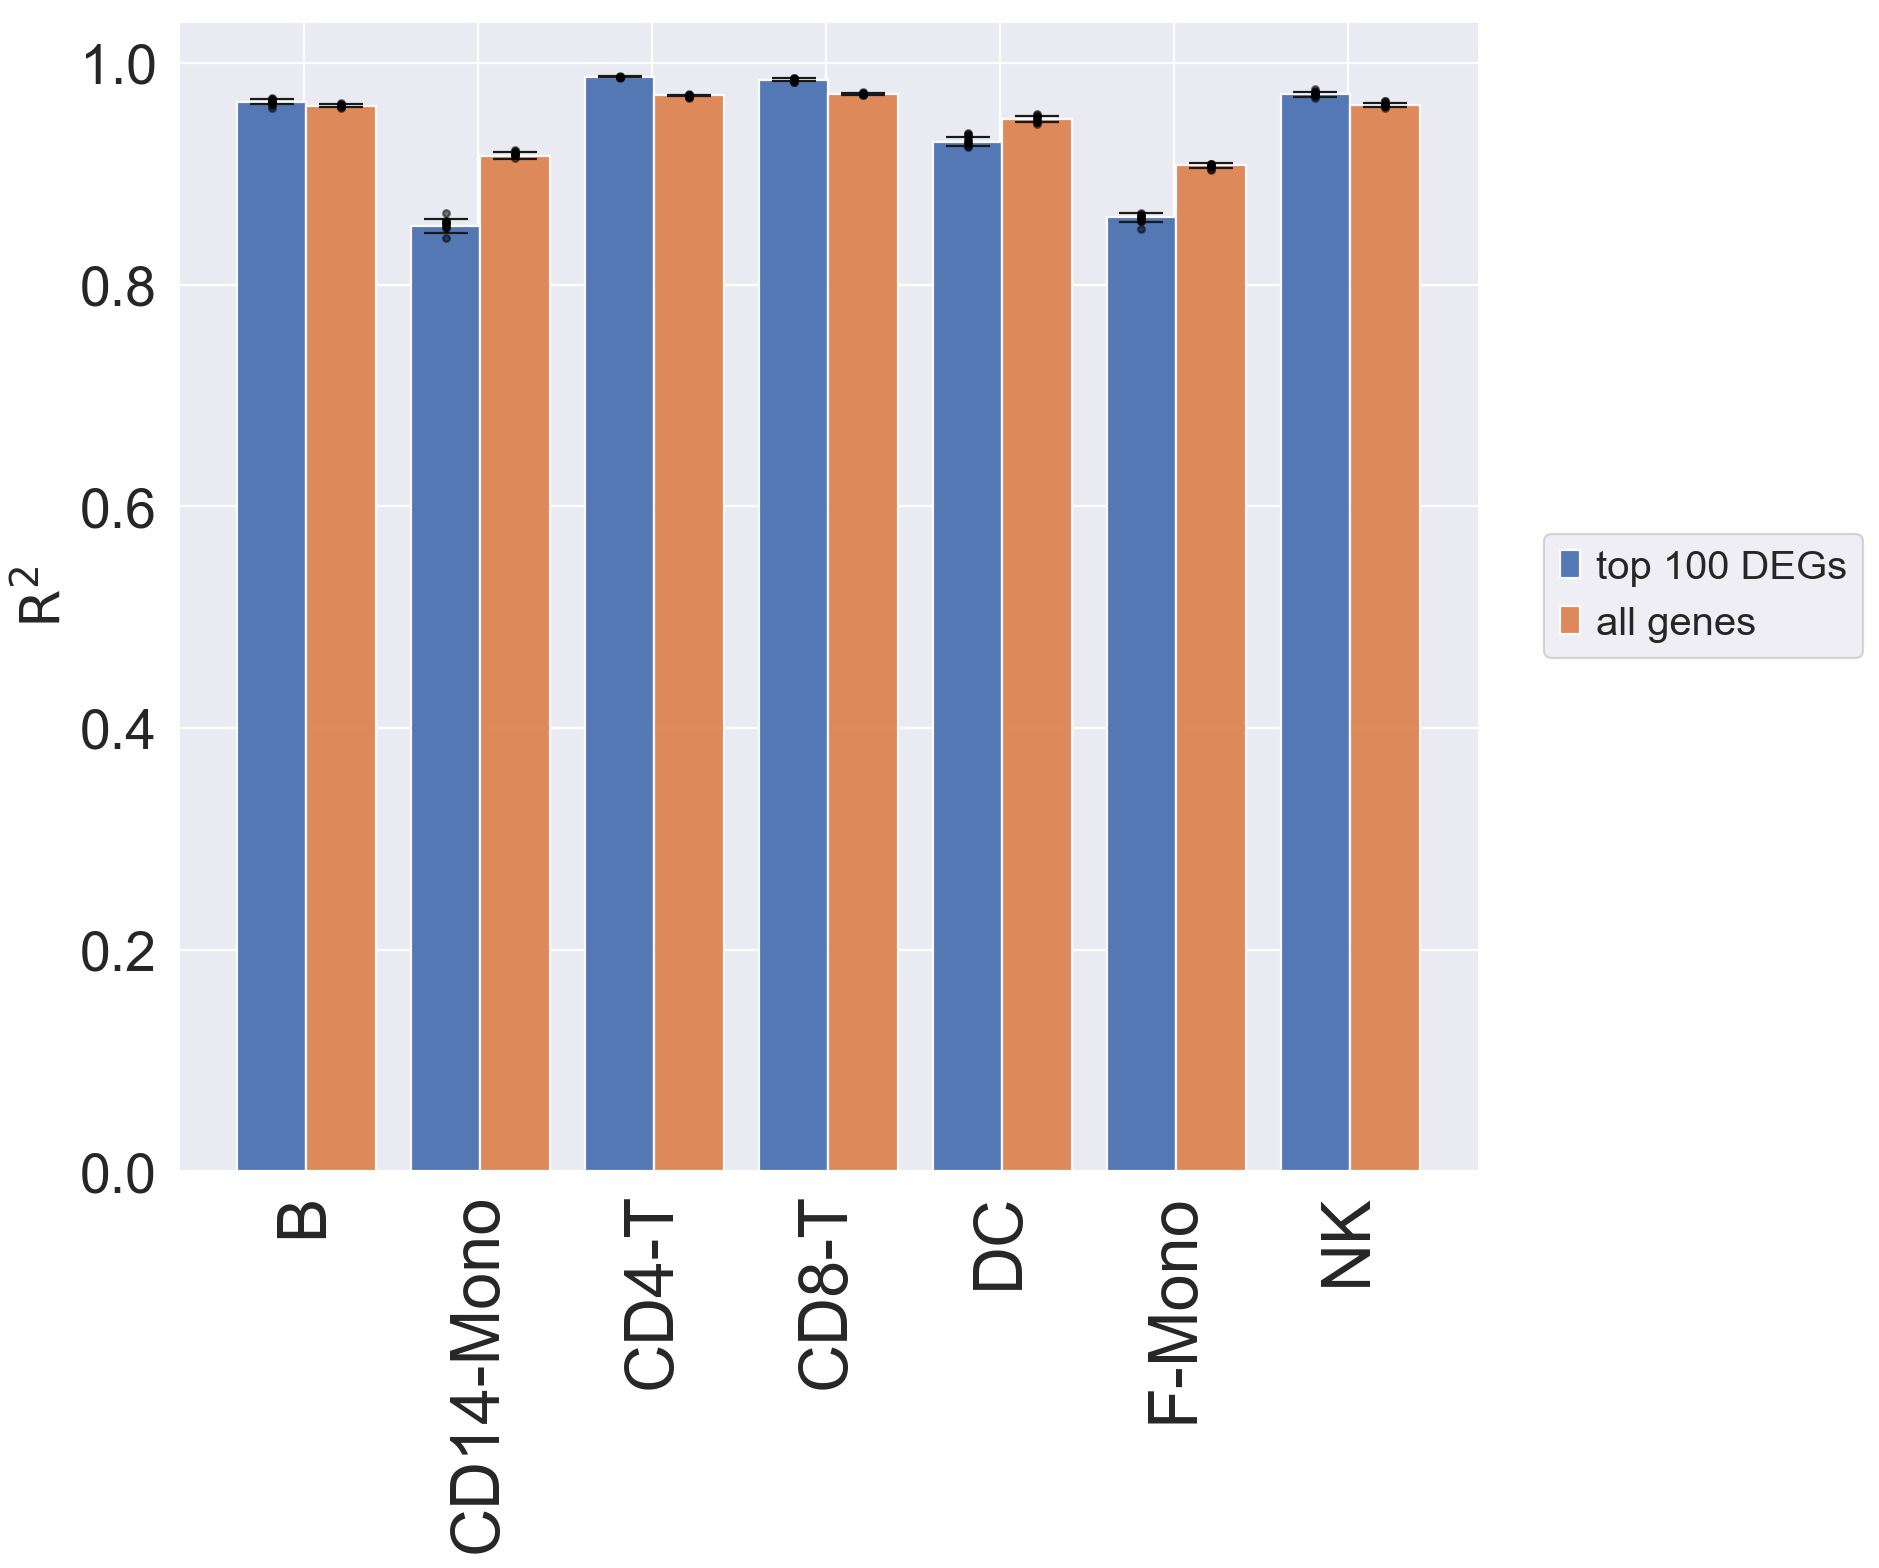

In [23]:
sns.set()
grouped_barplot(df, "Cell Types", "Type", "R^2 Means", "R^2 Stddevs", legend=True, filename="Fig2c_celltypes_barplots.pdf")

In [24]:
stgan_reconstructed = sc.read("../data/reconstructed/CGAN/CGAN_CD4T.h5ad")
pca_reconstructed = sc.read("../data/reconstructed/PCAVecArithm/PCA_CD4T.h5ad")
ges_reconstructed = sc.read("../data/reconstructed/VecArithm/VecArithm_CD4T.h5ad")
cvae_reconstructed = sc.read("../data/reconstructed/CVAE/CVAE_CD4T.h5ad")
replace_conditions(cvae_reconstructed)

In [25]:
ctrl = cd4t_reconstructed[cd4t_reconstructed.obs["condition"] == "CD4-T_ctrl"]
real_stim = cd4t_reconstructed[cd4t_reconstructed.obs["condition"] == "CD4-T_real_stim"]
scgen_pred_stim = cd4t_reconstructed[cd4t_reconstructed.obs["condition"] == "CD4-T_pred_stim"]
stgan_pred_stim = stgan_reconstructed[stgan_reconstructed.obs["condition"] == "pred_stim"]
ges_pred_stim = ges_reconstructed[ges_reconstructed.obs["condition"] == "pred_stim"]
pca_pred_stim = pca_reconstructed[pca_reconstructed.obs["condition"] == "pred_stim"]
cvae_pred_stim = cvae_reconstructed[cvae_reconstructed.obs["condition"] == "CD4-T_pred_stim"]

In [26]:
if sparse.issparse(cvae_pred_stim.X):
    cvae_pred_stim.X = cvae_pred_stim.X.A

In [27]:
ctrl.obs["condition"] = "control"
real_stim.obs["condition"] = "stimulation real"
scgen_pred_stim.obs["condition"] = "scGen"
cvae_pred_stim.obs["condition"] = "CVAE"
stgan_pred_stim.obs["condition"] = "style transfer GAN"
ges_pred_stim.obs["condition"] = "Vec. Arithm."
pca_pred_stim.obs["condition"] = "PCA + Vec. Arithm."

In [28]:
models = ctrl.concatenate(real_stim, scgen_pred_stim, cvae_pred_stim, stgan_pred_stim, ges_pred_stim, pca_pred_stim)
models.obs["condition"].unique()

array(['control', 'stimulation real', 'scGen', 'CVAE',
       'style transfer GAN', 'Vec. Arithm.', 'PCA + Vec. Arithm.'],
      dtype=object)

In [29]:
var_temp = models.var_names.tolist()
var_temp[var_temp.index("ISG15")] = "ISG15 in CD4-T"
models.var_names = var_temp

... storing 'cell_type' as categorical
... storing 'condition' as categorical


saving figure to file ../results/Figures/Figure 2/violin_model_cmpr.pdf


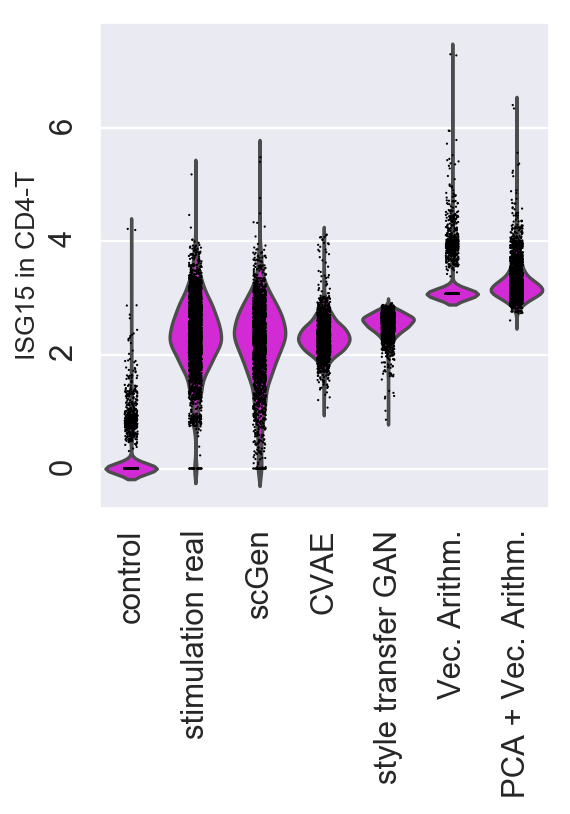

In [30]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys="ISG15 in CD4-T", 
             groupby="condition", 
             rotation=90,
             show=True,
             order=models.obs["condition"].unique().tolist(),
             color = "#ee0ef0",
             save="_model_cmpr.pdf"
            )
os.rename(src=os.path.join(path_to_save, "violin_model_cmpr.pdf"), 
          dst=os.path.join(path_to_save, "Fig2d_model_comparison.pdf"))

In [32]:
print(f"Control: {ctrl.shape[0]}")
print(f"Prediction: {scgen_pred_stim.shape[0]}")
print(f"Stimulated: {real_stim.shape[0]}")

Control: 2437
Prediction: 2437
Stimulated: 3127


In [216]:
conditions = {"real_stim": "CD4-T_real_stim", "pred_stim": "CD4-T_pred_stim"}
scgen_r2_mean, scgen_r2_var = calc_R2_specific_model(cd4t_reconstructed, n_genes=6998, conditions=conditions)
cvae_r2_mean, cvae_r2_var = calc_R2_specific_model(cvae_reconstructed, n_genes=6998, conditions=conditions)

0.9709417621535518 0.000795816726649298
0.9127632291851302 0.0008775502565928032


In [217]:
if sparse.issparse(cvae_reconstructed.X):
    cvae_reconstructed.X = cvae_reconstructed.X.A

In [218]:
conditions = {"real_stim": "real_stim", "pred_stim": "pred_stim"}
ges_r2_mean, ges_r2_var = calc_R2_specific_model(ges_reconstructed, n_genes=6998, conditions=conditions)
pca_r2_mean, pca_r2_var = calc_R2_specific_model(pca_reconstructed, n_genes=6998, conditions=conditions)
stgan_r2_mean, stgan_r2_var = calc_R2_specific_model(stgan_reconstructed, n_genes=6998, conditions=conditions)

0.8942153135824593 0.0011464654288153684
0.8962618106722648 0.001015143357519622
0.1310066652961454 0.0005605836675030229


In [219]:
all_means = np.array([scgen_r2_mean, cvae_r2_mean, stgan_r2_mean, ges_r2_mean, pca_r2_mean])
all_vars = np.array([scgen_r2_var, cvae_r2_var, stgan_r2_var, ges_r2_var, pca_r2_var])
all_types = ["All genes"] * 5
models = ["scGen", "CVAE", "style transfer GAN", "Vec. Arithm.", "PCA + Vec. Arithm.", ]
df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Models": models})
df

,R^2 Means,R^2 Stddevs,Type,Models
0,0.970942,0.000796,All genes,scGen
1,0.912763,0.000878,All genes,CVAE
2,0.131007,0.000561,All genes,style transfer GAN
3,0.894215,0.001146,All genes,Vec. Arithm.
4,0.896262,0.001015,All genes,PCA + Vec. Arithm.


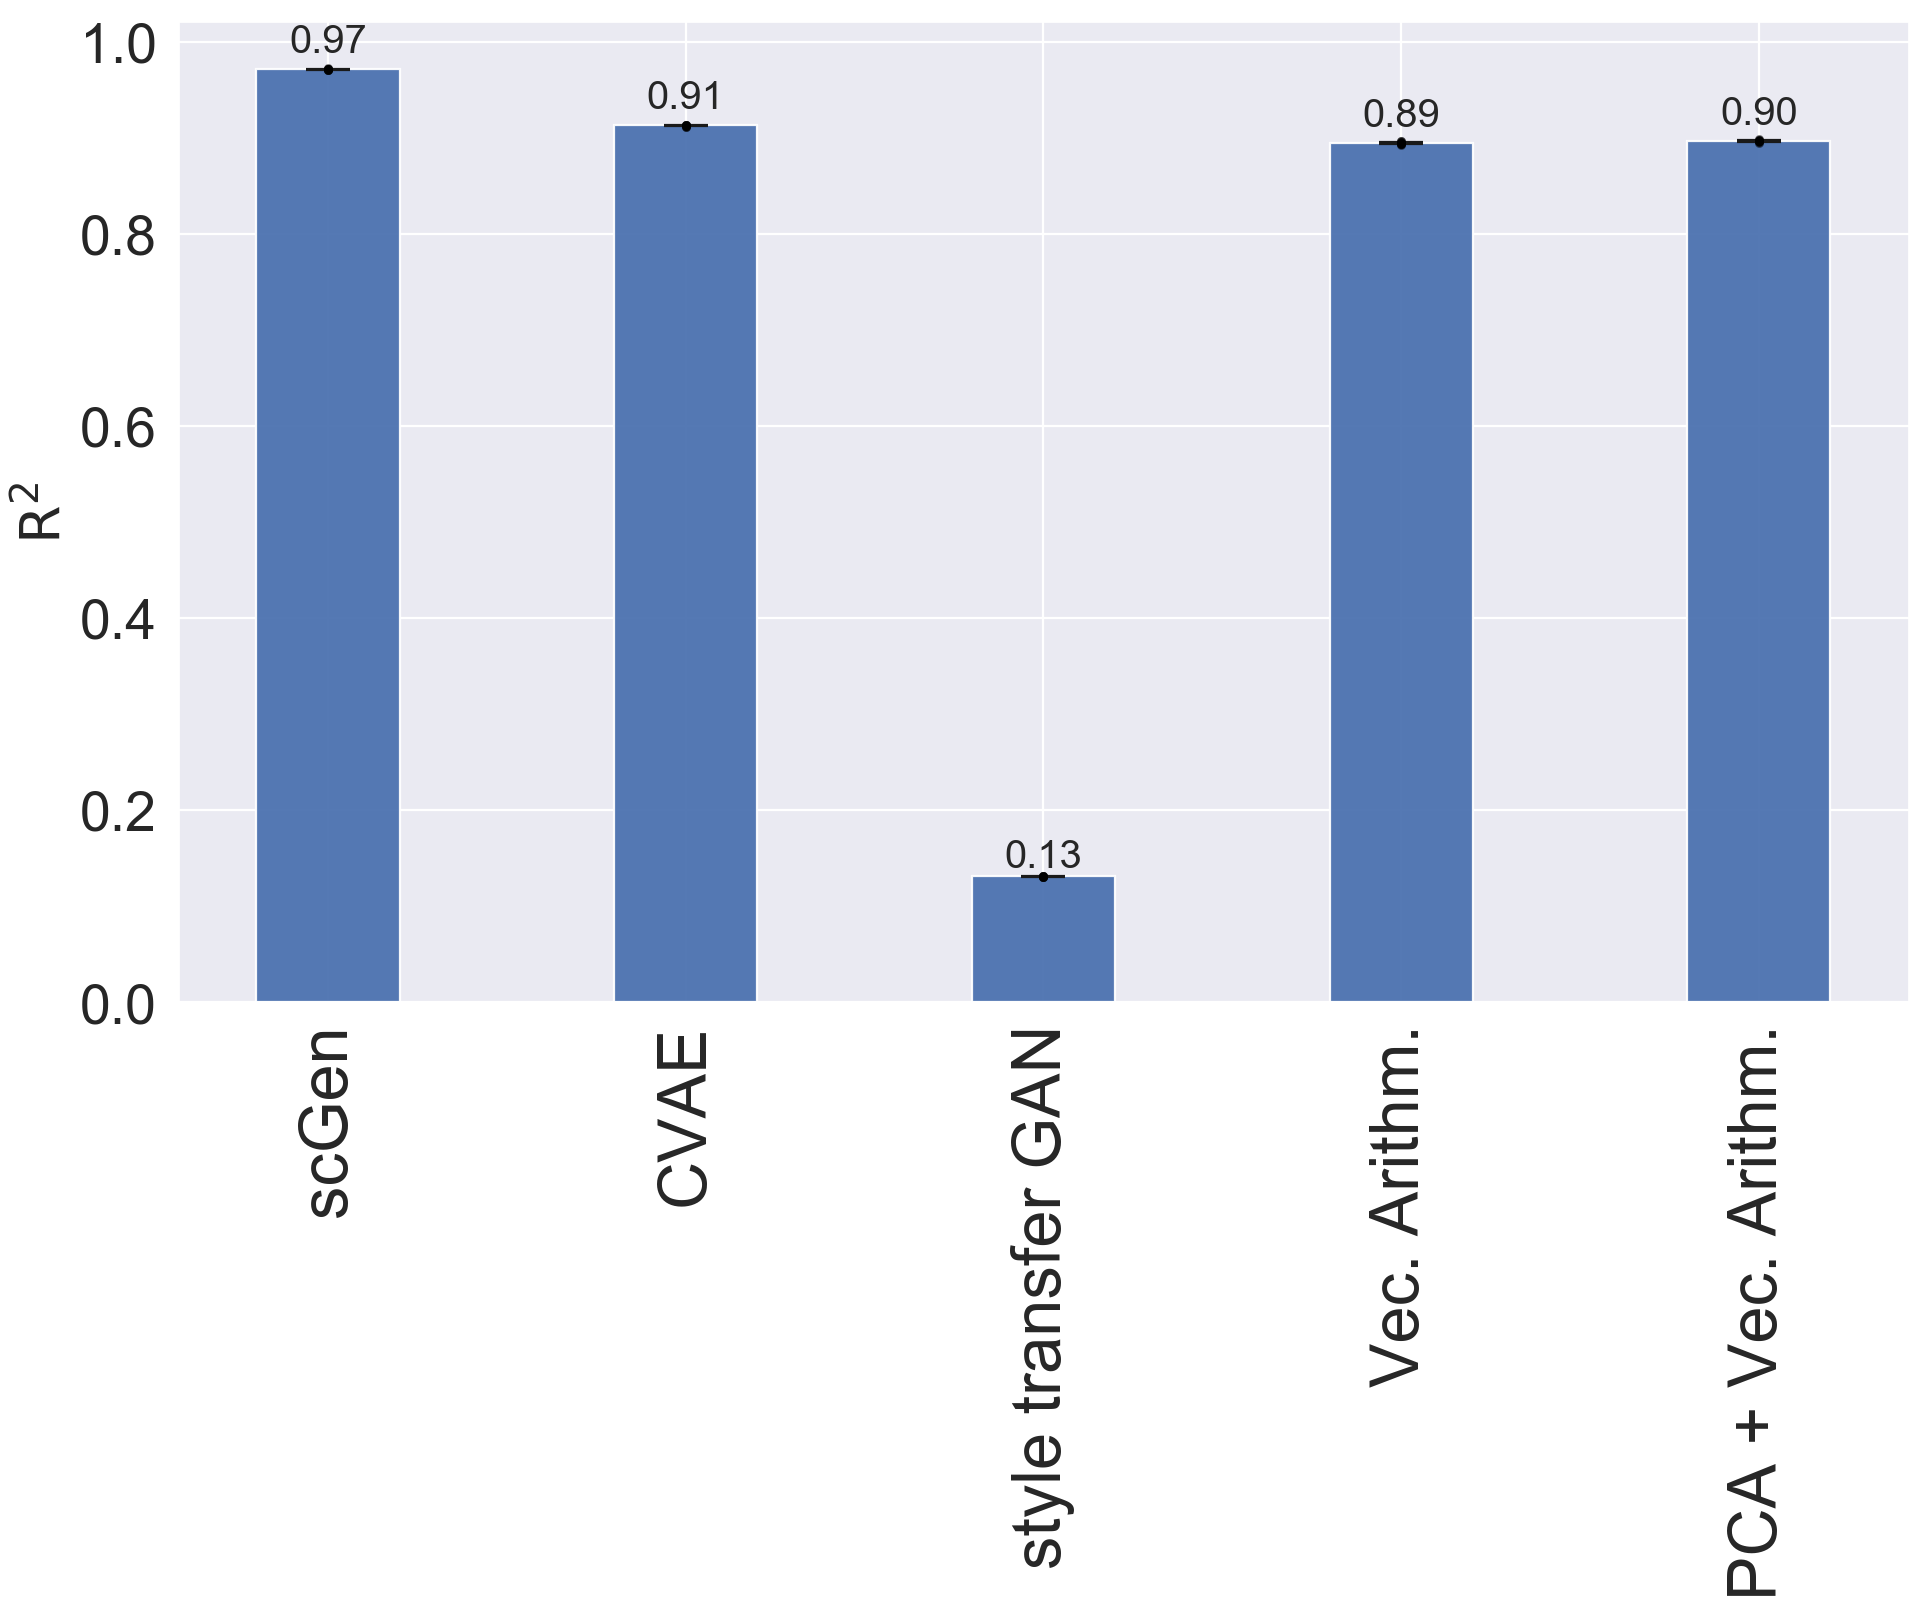

In [222]:
font = {'family' : 'Arial',
        'size'   : 2}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
grouped_barplot(df, "Models", "Type", "R^2 Means", "R^2 Stddevs", put_label=True, legend=False, filename="Fig2e_models_barplots.pdf", offset=0.0)

### Fig 2.g

In [223]:
gene_list = ["CD3D", "CCL5", "GNLY", "CD79A", "FCGR3A", "S100A9", "HLA-DQA1", 
             "ISG15", "IFI6", "IFIT1", "CXCL10", "CXCL11", "APOBEC3A", "DEFB1", 
             "CCL8", "TARBP1"]
pbmc_reconstructed.obs["condition"].replace("CD14+Mono_ctrl", "CD14-Mono_ctrl", inplace=True)
pbmc_reconstructed.obs["condition"].replace("CD14+Mono_real_stim", "CD14-Mono_real_stim", inplace=True)
pbmc_reconstructed.obs["condition"].replace("CD14+Mono_pred_stim", "CD14-Mono_pred_stim", inplace=True)
pbmc_reconstructed.obs["condition"].replace("Dendritic_ctrl", "DC_ctrl", inplace=True)
pbmc_reconstructed.obs["condition"].replace("Dendritic_real_stim", "DC_real_stim", inplace=True)
pbmc_reconstructed.obs["condition"].replace("Dendritic_pred_stim", "DC_pred_stim", inplace=True)
pbmc_reconstructed.obs["condition"].replace("FCGR3A+Mono_ctrl", "F-Mono_ctrl", inplace=True)
pbmc_reconstructed.obs["condition"].replace("FCGR3A+Mono_real_stim", "F-Mono_real_stim", inplace=True)
pbmc_reconstructed.obs["condition"].replace("FCGR3A+Mono_pred_stim", "F-Mono_pred_stim", inplace=True)

... storing 'cell_type' as categorical
... storing 'condition' as categorical


saving figure to file ../results/Figures/Figure 2/dotplot.pdf


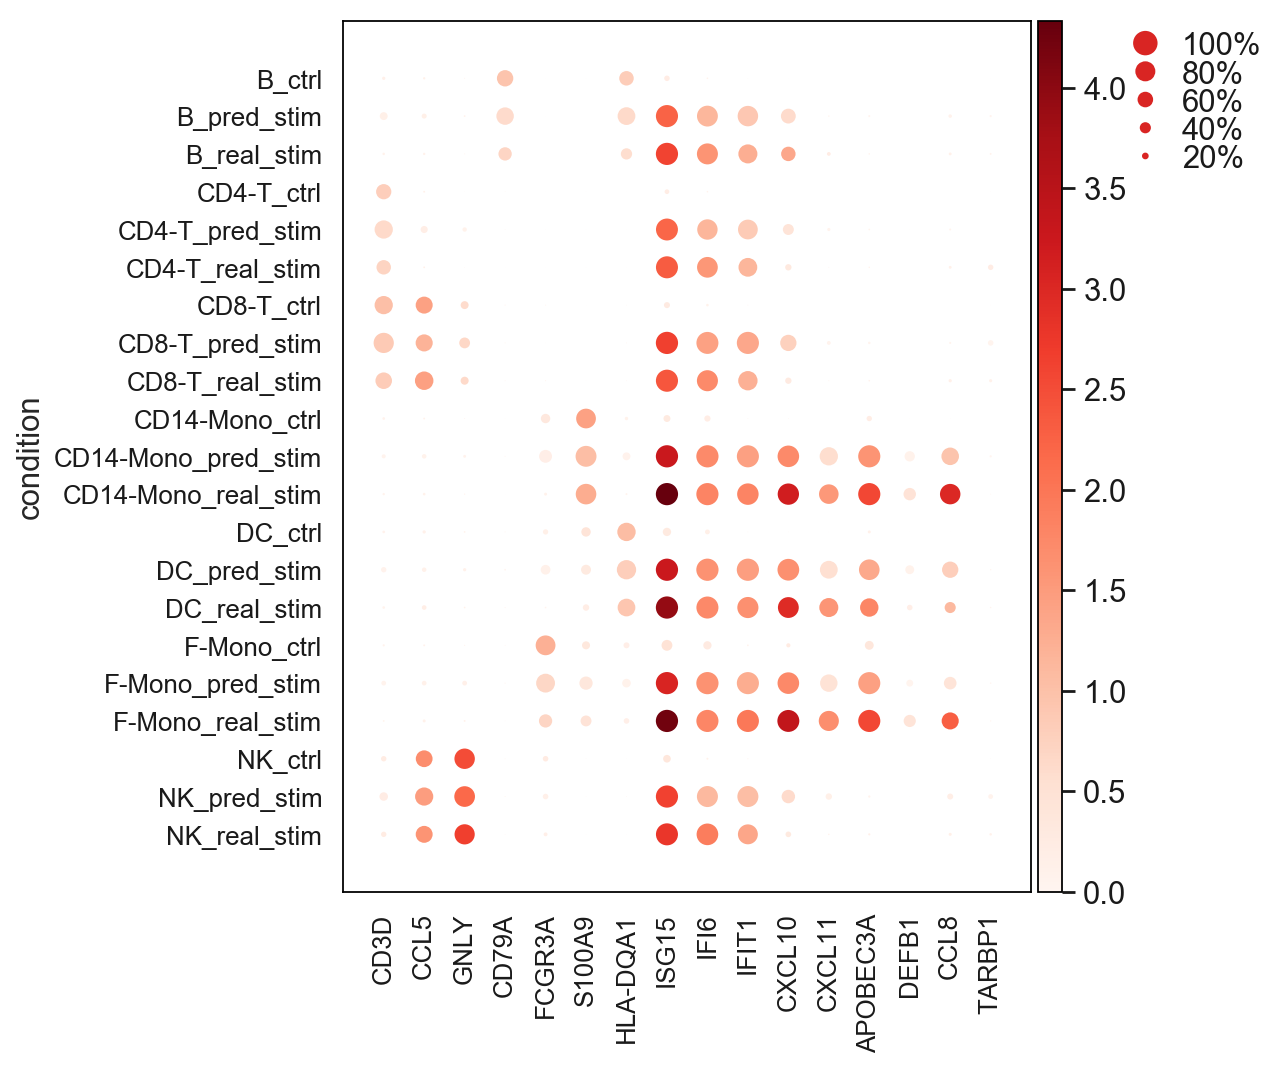

In [224]:
sc.set_figure_params(fontsize=14)
sc.pl.dotplot(pbmc_reconstructed, var_names=gene_list, groupby="condition", save=".pdf", show=True)
os.rename(src=os.path.join(path_to_save, "dotplot.pdf"), 
          dst=os.path.join(path_to_save, "Fig2f_dotplot.pdf"))